### 統計學習與深度學習 (Fall, 2024)
### Homework 3

請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。
如無其他規定，所有重要結果應顯示至小數點第四位(四捨五入)。


### 第一題 [Resnet as a Feature Extractor]

(30%) Resnet是一個常用的CNN影像分類的架構。許多深度學習平台，如Pytorch，提供已經在ImageNet資料集上訓練好的模型(i.e., 權重)。這些模型可以直接用來取代傳統的特徵工程。我們在本題與下一期要來嘗試與比較這個方向。

為了方便討論，我們使用Resnet50。當然同樣的作法可以用在其他類似的模型上。

Resnet50的模型架構大致上是

```
ResNet(
  (conv1):

   .... [omitted] ...

  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
)

```
我們忽略前面的所有層，只專注在最後一層。是一個線性層。輸入是2048維，輸出是1000維。因此如果要把訓練好的Resnet50當成是Feature Extractor，我們可以直些使用模型的最後輸出(尚未進入Softmax)的1000維向量，或是使用前一層的輸出，也就是2048維向量。本題將嘗試使用最後的1000維向量來代表一張圖片。下一題將使用前一層的輸出的2048維向量代表圖片。

請以Pytorch提供的預訓練模型(`torchvision.models.resnet50(weights="IMAGENET1K_V2")`)作為起點往下發展。

為了控制不同的分類器可能會帶來的影響。我們選用Logistic Regression作為最後圖片分類的分類器。也就是說每張在訓練集的圖片都通過同一個Pre-trained Resnet50，轉換成一個1000維的向量。然後訓練一個Logistic Regression做圖片分類。接下來把每一張測試資料通過同一個Pre-trained Resnet50轉換成1000維的向量。使用訓練好的Logistic Regression預測分類，並計算分類效能。

這裡的圖片分類任務我們選用Food101資料集。這個資料集有101類食物的照片。任務是看照片分類食物。

為了節省大家的資料整備時間，我們提供`food101_hwds.tgz`檔案。請下載並存放置工作目錄，並執行`tar zxvf food101_hwds.tgz ./`。你會在工作目錄看到一個food101目錄，下有一個food-101目錄，接下來是`images  license_agreement.txt  meta  README.txt`等檔案。

如果你的資料檔已經正確下載，就可以連上Data Loader:


In [ ]:
import torch
import torchvision
from torchvision import models, transforms, datasets

# 是否有 CUDA
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: Tesla T4


In [ ]:
imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

valid_tfms = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(imagenet_stats[0], imagenet_stats[1])])

batch_size = 196
trainset = torchvision.datasets.Food101(root='./food101', split="train",
                                        download=True, transform=valid_tfms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=6)

validset = torchvision.datasets.Food101(root='./food101', split="test",
                                       download=True, transform=valid_tfms)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                         shuffle=False, num_workers=6)

assert trainset.classes==validset.classes
classes = trainset.classes
classe2idx = trainset.class_to_idx
num_classes = len(classes)

print("Number of classes =", num_classes)

100%|██████████| 5.00G/5.00G [02:39<00:00, 31.3MB/s]


Extracting ./food101/food-101.tar.gz to ./food101


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Number of classes = 101


這裡有101個分類。列出前幾個給大家參考:

In [ ]:
print(trainset.classes[0:10])

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


為了給大家更具體的想法，下面是一些訓練集的照片與分類:

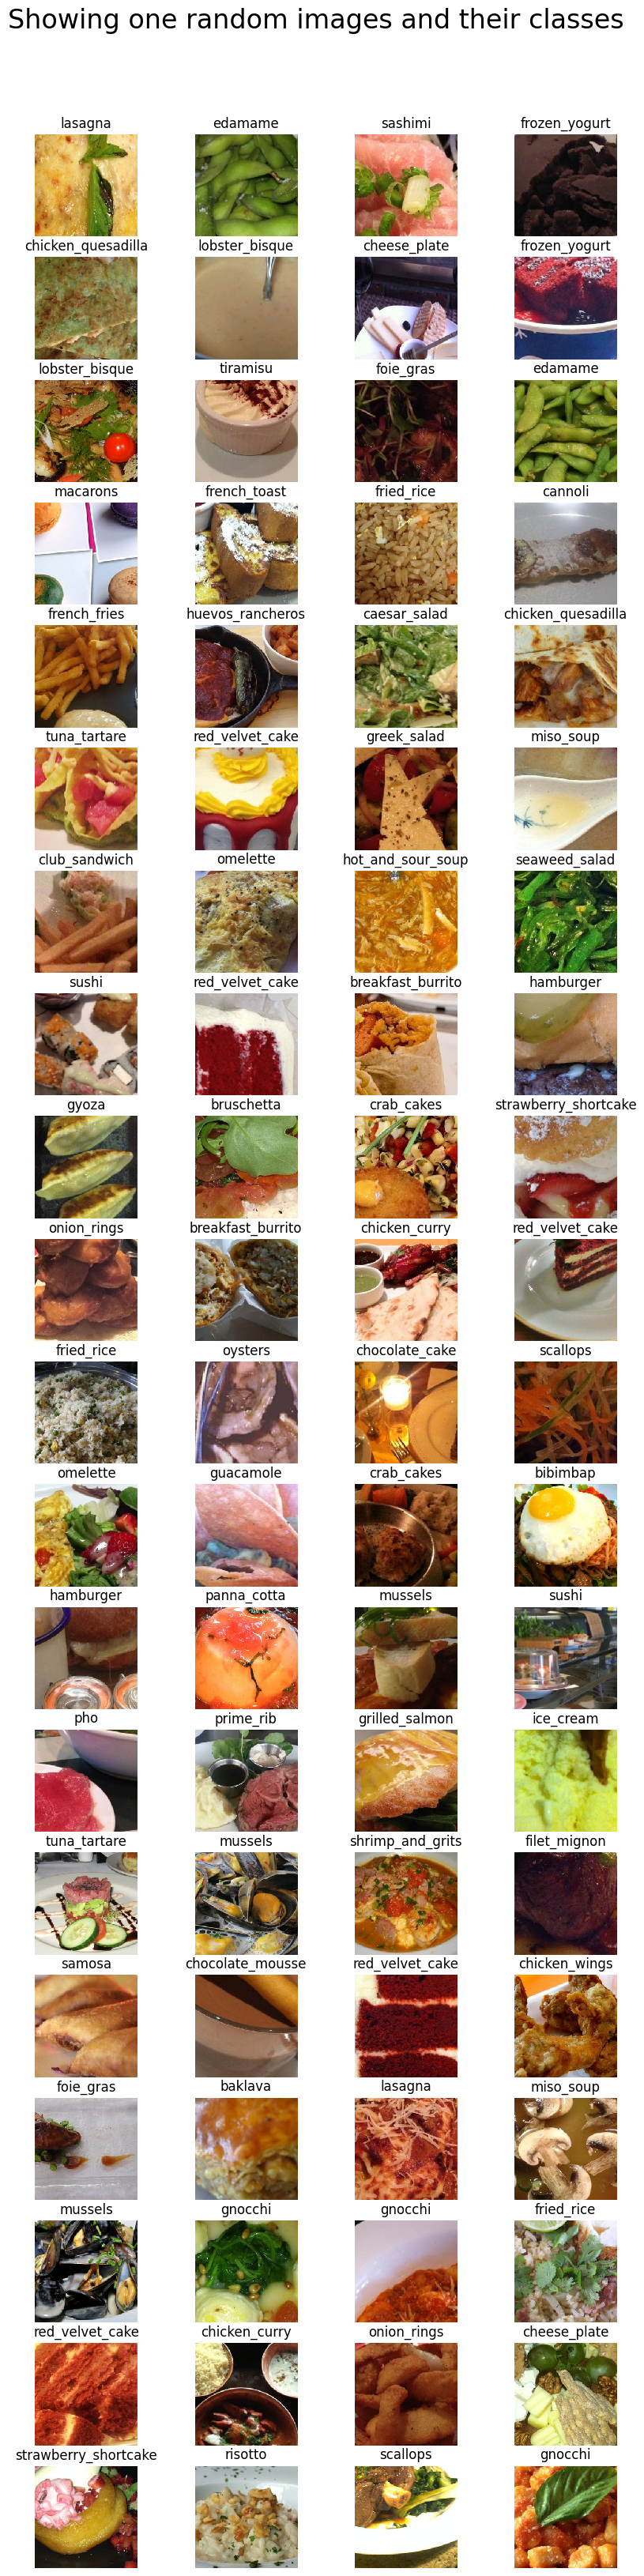

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,40))
fig.suptitle(f"Showing one random images and their classes", y=0.92, fontsize=24)
columns = 4
rows = 20
imgenet_mean = imagenet_stats[0]
imgenet_std = imagenet_stats[1]

targetset = trainset
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)

    img_xy = np.random.randint(len(targetset));
    np_img = targetset[img_xy][0].numpy()
    img = np.transpose(np_img, (1,2,0))
    img = img * imgenet_std + imgenet_mean

    plt.title(classes[targetset[img_xy][1]])
    plt.axis('off')
    img = np.clip(img, 0, 1)
    plt.imshow(img, interpolation='nearest')

plt.show()

注意:
1. 由於訓練集較大，請隨機在訓練集選取20000張照片訓練Logistic Regression。
2. 請不要調整測試集(Validation Set)
3. 本題主要的分類效能指標為Accuracy與Macro-average F1

In [ ]:
# 檢查是否有 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# 隨機選取 20000 張訓練圖片
train_indices = np.random.choice(len(trainset), 20000, replace=False)
train_subset = torch.utils.data.Subset(trainset, train_indices)

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# 載入 ResNet50 模型
resnet50 = models.resnet50(weights="IMAGENET1K_V2")
resnet50 = resnet50.to(device)  # 移動到 GPU
resnet50.eval()  # 評估模式

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from sklearn.linear_model import LogisticRegression

def extract_features(dataloader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)  # 移動到 GPU
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())  # 將輸出移動到 CPU 並轉換為 numpy 陣列
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# 提取訓練和驗證集的特徵
train_features, train_labels = extract_features(trainloader, resnet50, device)
valid_features, valid_labels = extract_features(validloader, resnet50, device)

# 訓練 Logistic Regression
log_reg = LogisticRegression(max_iter=1000, verbose=1, n_jobs=-1)
log_reg.fit(train_features, train_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LogisticRegression(max_iter=1000, n_jobs=-1, verbose=1)

In [ ]:
print(train_features.shape, len(train_labels), valid_features.shape, len(valid_labels))

(20000, 1000) 20000 (25250, 1000) 25250


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# 預測驗證集
valid_preds = log_reg.predict(valid_features)

# 計算模型表現
accuracy = accuracy_score(valid_labels, valid_preds)
macro_f1 = f1_score(valid_labels, valid_preds, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro-average F1: {macro_f1:.4f}")

Accuracy: 0.5227
Macro-average F1: 0.5225


----

### 第二題 [Resnet as a Feature Extractor, Part 2]

(20%) 呈上題，使用最後fc輸入的2048維作為特徵。訓練Logistic Regression，並計算分類績效。注意事項與前一題一樣。比較這兩種作法的結果。你覺得應該使用2048維或1000為作為特徵向量?

In [ ]:
resnet50_2 = models.resnet50(weights="IMAGENET1K_V2")
resnet50_2.fc = torch.nn.Identity()  # 將最後的全連接層替換為 Identity 層變成 2048 維輸出
resnet50_2 = resnet50_2.to(device)
resnet50_2.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def extract_features_2048(dataloader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

train_features_2048, train_labels_2048 = extract_features_2048(trainloader, resnet50_2, device)
valid_features_2048, valid_labels_2048 = extract_features_2048(validloader, resnet50_2, device)

In [ ]:
print(train_features_2048.shape, len(train_labels_2048), valid_features_2048.shape, len(valid_labels_2048))

(20000, 2048) 20000 (25250, 2048) 25250


In [ ]:
log_reg_2048 = LogisticRegression(max_iter=1000, verbose=1, n_jobs=-1)
log_reg_2048.fit(train_features_2048, train_labels_2048)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LogisticRegression(max_iter=1000, n_jobs=-1, verbose=1)

In [ ]:
valid_preds_2048 = log_reg_2048.predict(valid_features_2048)

accuracy_2048 = accuracy_score(valid_labels_2048, valid_preds_2048)
macro_f1_2048 = f1_score(valid_labels_2048, valid_preds_2048, average='macro')

print(f"Accuracy: {accuracy_2048:.4f}")
print(f"Macro-average F1: {macro_f1_2048:.4f}")

Accuracy: 0.5530
Macro-average F1: 0.5527


#### 比較使用 Resnet50 最後一層輸出 1000 維做為特徵向量，以及 Resnet 50 最後一層輸入 2048 維作為特徵向量可以發現，使用 2048 維作為 Logistic Regression 的訓練特徵在驗證集的 Accuracy、Macro-average 預測表現上較好，這可能是因為最後一層全連接層的輸入相較輸出提取的特徵保留了更多細節，從而提升分類器在訓練上的性能。因此會建議在這個圖片分類中使用 ResNet50 模型的最後一層全連接層的輸入 2048 維特徵向量來訓練 Logistic Regression 模型。

------



### 第三題 [Resnet Finetuning]

(50%) 接下來我們來嘗試一般的Fine-tuning作法。這個作法是以Pre-trained Resnet50做為起點，將最後一層(fc)換成適合這個分類任務的維度，也就是2048 --> 101的線性層，然後進行模型的Fine-tuning (i.e., training)。

這裡通常有兩種作法，一是在Back Propogation時調整所有的權重，二是只調整最後的fc層。請嘗試並比較這兩者的差別。

注意事項:
* 影像前處理在訓練階段與測試階段不同。訓練階段需要有RandomResizedCrop()與RandomHorizontalFlip()。測試階段則只需CenterCrop()。所有階段都需標準化。
* 訓練時請使用Early Stopping。Patient ＝ 5 epochs。最多訓練100 epochs
* 請使用全部訓練集與測試集。
* 本題主要的分類效能指標為Accuracy與Macro-average F1
* 請提供training loss, validation loss, validation accuracy, validation macro f1在訓練期間的線圖。
* 為了簡化問題。我們以訓練期間最佳的validation performance作為模型的一般性預測力指標。


In [1]:
import torch
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
# 影像前處理
imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
])

valid_tfms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
])

In [3]:
batch_size = 196

trainset = torchvision.datasets.Food101(root='./food101', split="train",
                                        download=True, transform=train_tfms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validset = torchvision.datasets.Food101(root='./food101', split="test",
                                       download=True, transform=valid_tfms)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 5.00G/5.00G [04:11<00:00, 19.9MB/s]


Extracting ./food101/food-101.tar.gz to ./food101


In [4]:
assert trainset.classes==validset.classes
classes = trainset.classes
classe2idx = trainset.class_to_idx
num_classes = len(classes)

print("Number of classes = ", num_classes, "Number of trainset = ", len(trainset), "Number of validset = ", len(validset))

Number of classes =  101 Number of trainset =  75750 Number of validset =  25250


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
def initialize_model(fine_tune_all=True):
    model = models.resnet50(weights="IMAGENET1K_V2")
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 101)  # 將最後的全連接層替換為 2048 -> 101 的線性層
    model = model.to(device)

    if not fine_tune_all:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    return model

def train_model(model, criterion, optimizer, trainloader, validloader, num_epochs=100, patience=5):
    scaler = torch.cuda.amp.GradScaler()  # 使用混合精度訓練
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0
    patience_counter = 0

    train_losses = []
    valid_losses = []
    valid_accuracies = []
    valid_f1s = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 訓練階段
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # 使用混合精度訓練
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(trainloader.dataset)
        train_losses.append(epoch_loss)

        # 驗證階段
        model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in validloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.cuda.amp.autocast():  # 使用混合精度訓練
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(validloader.dataset)
        valid_losses.append(epoch_loss)

        epoch_acc = accuracy_score(all_labels, all_preds)
        valid_accuracies.append(epoch_acc)

        epoch_f1 = f1_score(all_labels, all_preds, average='macro')
        valid_f1s.append(epoch_f1)

        print(f'Training Loss: {train_losses[-1]:.4f} Validation Loss: {valid_losses[-1]:.4f} Validation Acc: {epoch_acc:.4f} Validation F1: {epoch_f1:.4f}')

        # Early Stopping
        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping')
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_accuracies, valid_f1s, best_acc, best_f1

In [7]:
def plot_metrics(train_losses, valid_losses, valid_accuracies, valid_f1s, title):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.plot(epochs, valid_f1s, label='Validation Macro F1')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title(f'{title} - Accuracy and Macro F1')
    plt.legend()

    plt.show()

In [ ]:
# 只調整最後的全連接層
model_fc = initialize_model(fine_tune_all=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_fc.fc.parameters(), lr=0.001, weight_decay=0.01)

model_fc, train_losses_fc, valid_losses_fc, valid_accuracies_fc, valid_f1s_fc, best_acc_fc, best_f1_fc = train_model(
    model_fc, criterion, optimizer, trainloader, validloader, num_epochs=100, patience=5
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


Epoch 0/99
----------


<ipython-input-6-0b9114fea8dc>:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 3.0559 Validation Loss: 2.4444 Validation Acc: 0.4503 Validation F1: 0.4377
Epoch 1/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 2.2199 Validation Loss: 2.1479 Validation Acc: 0.4924 Validation F1: 0.4818
Epoch 2/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.9997 Validation Loss: 2.0073 Validation Acc: 0.5149 Validation F1: 0.5048
Epoch 3/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.8853 Validation Loss: 1.9368 Validation Acc: 0.5295 Validation F1: 0.5220
Epoch 4/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.8037 Validation Loss: 1.8906 Validation Acc: 0.5396 Validation F1: 0.5330
Epoch 5/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.7453 Validation Loss: 1.8575 Validation Acc: 0.5438 Validation F1: 0.5361
Epoch 6/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.6995 Validation Loss: 1.8323 Validation Acc: 0.5491 Validation F1: 0.5426
Epoch 7/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.6706 Validation Loss: 1.8165 Validation Acc: 0.5510 Validation F1: 0.5474
Epoch 8/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.6422 Validation Loss: 1.8108 Validation Acc: 0.5499 Validation F1: 0.5445
Epoch 9/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.6044 Validation Loss: 1.7938 Validation Acc: 0.5542 Validation F1: 0.5463
Epoch 10/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.5942 Validation Loss: 1.7653 Validation Acc: 0.5589 Validation F1: 0.5526
Epoch 11/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.5639 Validation Loss: 1.7603 Validation Acc: 0.5594 Validation F1: 0.5549
Epoch 12/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.5543 Validation Loss: 1.7536 Validation Acc: 0.5604 Validation F1: 0.5546
Epoch 13/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.5424 Validation Loss: 1.7556 Validation Acc: 0.5613 Validation F1: 0.5562
Epoch 14/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.5324 Validation Loss: 1.7434 Validation Acc: 0.5649 Validation F1: 0.5596
Epoch 15/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.5130 Validation Loss: 1.7384 Validation Acc: 0.5645 Validation F1: 0.5584
Epoch 16/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.4985 Validation Loss: 1.7505 Validation Acc: 0.5595 Validation F1: 0.5554
Epoch 17/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.5012 Validation Loss: 1.7438 Validation Acc: 0.5618 Validation F1: 0.5567
Epoch 18/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.4874 Validation Loss: 1.7393 Validation Acc: 0.5636 Validation F1: 0.5582
Epoch 19/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.4740 Validation Loss: 1.7313 Validation Acc: 0.5669 Validation F1: 0.5635
Epoch 20/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.4679 Validation Loss: 1.7273 Validation Acc: 0.5652 Validation F1: 0.5604
Epoch 21/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.4610 Validation Loss: 1.7284 Validation Acc: 0.5646 Validation F1: 0.5592
Epoch 22/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.4579 Validation Loss: 1.7310 Validation Acc: 0.5649 Validation F1: 0.5605
Epoch 23/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.4566 Validation Loss: 1.7266 Validation Acc: 0.5638 Validation F1: 0.5616
Epoch 24/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.4495 Validation Loss: 1.7269 Validation Acc: 0.5646 Validation F1: 0.5602
Early stopping


In [ ]:
# 保存模型
torch.save(model_fc.state_dict(), 'resnet50_fine_tuned_fc.pth')

------


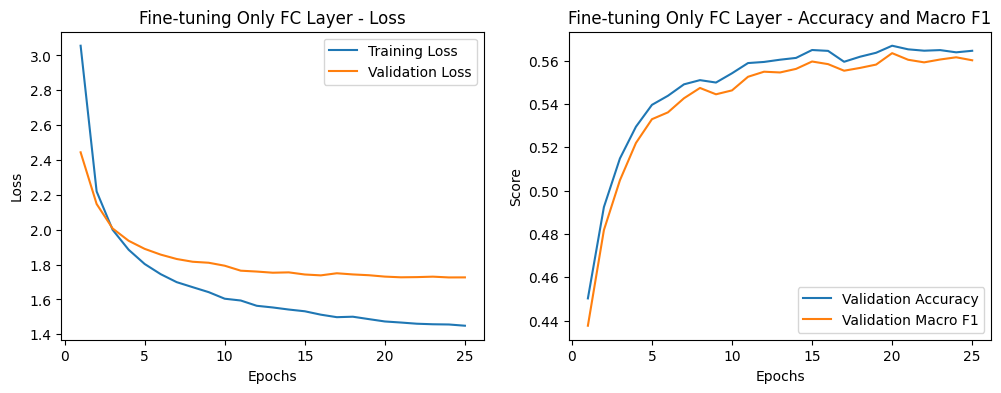

In [ ]:
plot_metrics(train_losses_fc, valid_losses_fc, valid_accuracies_fc, valid_f1s_fc, 'Fine-tuning Only FC Layer')

In [ ]:
print(f'Fine-tuning Only FC Layer - Best Validation Accuracy: {best_acc_fc:.4f}, Best Validation Macro-average F1: {best_f1_fc:.4f}')

Fine-tuning Only FC Layer - Best Validation Accuracy: 0.5669, Best Validation Macro-average F1: 0.5635

In [8]:
# 調整所有權重
model_all = initialize_model(fine_tune_all=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_all.parameters(), lr=0.001, weight_decay=0.01)

model_all, train_losses_all, valid_losses_all, valid_accuracies_all, valid_f1s_all, best_acc_all, best_f1_all = train_model(
    model_all, criterion, optimizer, trainloader, validloader, num_epochs=100, patience=5
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


Epoch 0/99
----------


<ipython-input-6-0b9114fea8dc>:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 2.0343 Validation Loss: 1.7333 Validation Acc: 0.5603 Validation F1: 0.5562
Epoch 1/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.4069 Validation Loss: 1.5110 Validation Acc: 0.6053 Validation F1: 0.6058
Epoch 2/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.2382 Validation Loss: 1.3606 Validation Acc: 0.6462 Validation F1: 0.6470
Epoch 3/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.1226 Validation Loss: 1.2628 Validation Acc: 0.6709 Validation F1: 0.6704
Epoch 4/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 1.0374 Validation Loss: 1.2636 Validation Acc: 0.6695 Validation F1: 0.6675
Epoch 5/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 0.9830 Validation Loss: 1.3022 Validation Acc: 0.6613 Validation F1: 0.6625
Epoch 6/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 0.9210 Validation Loss: 1.0764 Validation Acc: 0.7137 Validation F1: 0.7166
Epoch 7/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 0.8737 Validation Loss: 1.2610 Validation Acc: 0.6724 Validation F1: 0.6776
Epoch 8/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 0.8323 Validation Loss: 1.1725 Validation Acc: 0.6915 Validation F1: 0.6905
Epoch 9/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 0.8017 Validation Loss: 1.0933 Validation Acc: 0.7121 Validation F1: 0.7112
Epoch 10/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 0.7575 Validation Loss: 1.2793 Validation Acc: 0.6688 Validation F1: 0.6711
Epoch 11/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 0.7353 Validation Loss: 0.9988 Validation Acc: 0.7371 Validation F1: 0.7374
Epoch 12/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 0.7016 Validation Loss: 1.0968 Validation Acc: 0.7126 Validation F1: 0.7132
Epoch 13/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 0.6784 Validation Loss: 1.1488 Validation Acc: 0.7055 Validation F1: 0.7061
Epoch 14/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 0.6535 Validation Loss: 1.0839 Validation Acc: 0.7139 Validation F1: 0.7139
Epoch 15/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 0.6233 Validation Loss: 1.0543 Validation Acc: 0.7287 Validation F1: 0.7300
Epoch 16/99
----------


<ipython-input-6-0b9114fea8dc>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
<ipython-input-6-0b9114fea8dc>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練


Training Loss: 0.5971 Validation Loss: 1.1111 Validation Acc: 0.7143 Validation F1: 0.7146
Early stopping


In [9]:
# 保存模型
torch.save(model_all.state_dict(), 'resnet50_fine_tuned_all.pth')

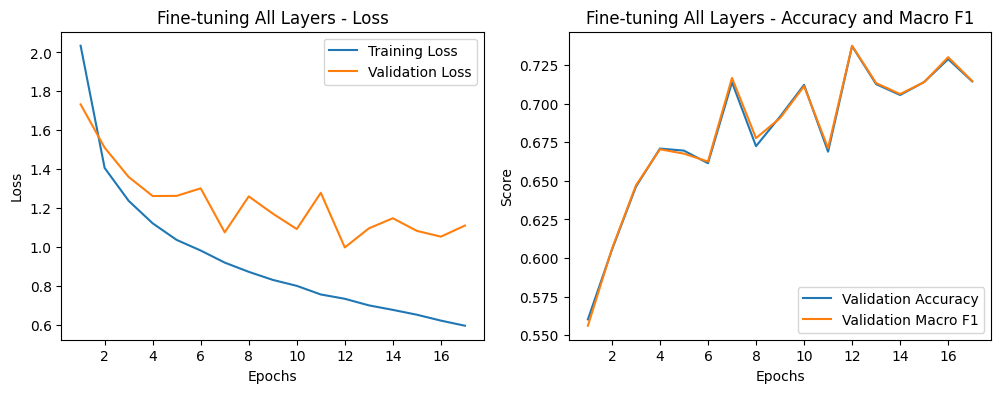

In [10]:
plot_metrics(train_losses_all, valid_losses_all, valid_accuracies_all, valid_f1s_all, 'Fine-tuning All Layers')

In [11]:
print(f'Fine-tuning All Layers - Best Validation Accuracy: {best_acc_all:.4f}, Best Validation Macro-average F1: {best_f1_all:.4f}')

Fine-tuning All Layers - Best Validation Accuracy: 0.7371, Best Validation Macro-average F1: 0.7374


#### 比較 Fine-tuning 所有層和只 Fine-tuning 最後的全連接層在驗證集上的表現有顯著差異。Fine-tuning 所有層的 Best Validation Accuracy 為 0.7371，Best Validation Macro-average F1 為 0.7374，同時 Validation Losses、Validation Accuracies,、Validation Macro F1 在圖形上比較多鋸齒狀。而 Fine-tuning 只調整最後的全連接層 Best Validation Accuracy 為 0.5669，Best Validation Macro-average F1 為 0.5635，同時 Validation Losses、Validation Accuracies、Validation Macro F1 在圖形上比較平滑。
#### 也就是說 Fine-tuning 所有層因為模型在新的資料集上進行全面的調整，能夠學習到更多與新資料集相關的特徵，能夠擁有較佳的模型表現。但其在訓練過程中，validation loss、accuracy 和 Macro-average F1 波動較大，可能是因為模型在調整所有層時，學習率較高或數據增強帶來的隨機性，在訊練時間上也更長，計算資源需求更高。
#### 相較之下 Fine-tuning 只調整最後的全連接層表現沒有那麼好，因其在新的資料集上進行的調整有限，無法充分學習到新資料集的特徵。但其訓練時間較短，計算資源需求較低，且在訓練過程中，validation loss、accuracy 和 Macro-average F1 較平滑，更加穩定一些。